# Stroke Prediction
 - Data aquired from: https://www.kaggle.com/fedesoriano/stroke-prediction-dataset
 - Code to be used for a blog post on handling imbalanced data.

#### Importing Libraries

In [216]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, balanced_accuracy_score,\
                            precision_score, recall_score, roc_auc_score,\
                            plot_confusion_matrix, classification_report, plot_roc_curve, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
#from category_encoders import OneHotEncoder
from sklearn.compose import make_column_transformer, make_column_selector

In [288]:
from imblearn.pipeline import make_pipeline
from sklearn.ensemble import IsolationForest

# Data Import & Cleaning

In [202]:
df = pd.read_csv('./data/healthcare-dataset-stroke-data.csv')

In [203]:
df.head(3)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1


In [5]:
df.shape

(5110, 12)

In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4909 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 4909 non-null   int64  
 1   gender             4909 non-null   int64  
 2   age                4909 non-null   float64
 3   hypertension       4909 non-null   int64  
 4   heart_disease      4909 non-null   int64  
 5   ever_married       4909 non-null   int64  
 6   work_type          4909 non-null   object 
 7   Residence_type     4909 non-null   int64  
 8   avg_glucose_level  4909 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     4909 non-null   object 
 11  stroke             4909 non-null   int64  
dtypes: float64(3), int64(7), object(2)
memory usage: 498.6+ KB


Binarizing / Vectorizing where possible:

In [65]:
for i in ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']:
    print(df[i].unique())

[1 0]
[1 0]
['Private' 'Self-employed' 'Govt_job' 'children' 'Never_worked']
[1 0]
['formerly smoked' 'never smoked' 'smokes' 'Unknown']


In [209]:
df['gender'] = np.where(df['gender'] == 'Male', 1, 0)

In [210]:
df['ever_married'] = np.where(df['ever_married'] == 'Yes', 1, 0)

In [211]:
df['Residence_type'] = np.where(df['Residence_type'] == 'Urban', 1, 0)

In [207]:
df['smoking_status'] = np.where(((df['smoking_status'] == 'smokes') | (df['smoking_status'] == 'formerly smoked')), 1, 0)

In [208]:
df.smoking_status.value_counts()

0    3436
1    1674
Name: smoking_status, dtype: int64

In [212]:
df.dropna(subset = ['bmi'], inplace = True)

Highly imbalanced classes:

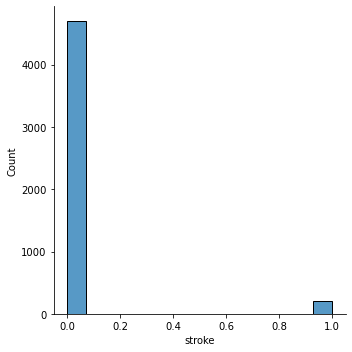

In [213]:
sns.displot(df.stroke);

In [214]:
df.stroke.value_counts()

0    4700
1     209
Name: stroke, dtype: int64

Removing outliers:

In [218]:
iso = IsolationForest(n_estimators = 1000, contamination = 0.1)

In [220]:
outs = pd.Series(iso.fit_predict(df[['bmi', 'avg_glucose_level']]))

In [221]:
outs.value_counts()

 1    4418
-1     491
dtype: int64

In [222]:
df = pd.concat([outs.reset_index(), df.reset_index()], axis = 1, ignore_index = False).drop(columns = 'index')

In [223]:
df.head(3)

,0,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,-1,9046,1,67.0,0,1,1,Private,1,228.69,36.6,1,1
1,1,31112,1,80.0,0,1,1,Private,0,105.92,32.5,0,1
2,1,60182,0,49.0,0,0,1,Private,1,171.23,34.4,1,1


In [224]:
df = df[df[0] == 1]

In [225]:
df.shape

(4418, 13)

In [226]:
df['stroke'].value_counts()

0    4246
1     172
Name: stroke, dtype: int64

# Visualizations

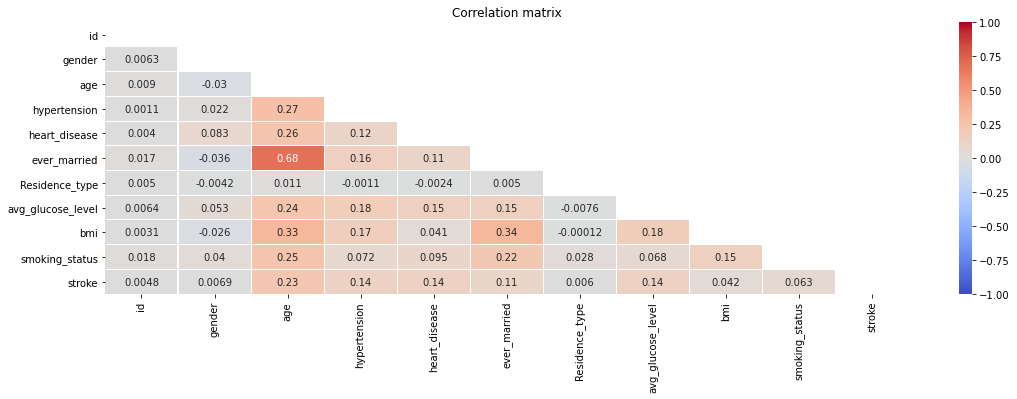

In [215]:
import matplotlib.pyplot as plt
mask = np.zeros_like(df.corr())
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(18, 5))
sns.heatmap(
    df.corr(),
    cmap='coolwarm',
    annot=True,
    mask=mask,
    vmin=-1.,
    vmax=1.,
    linewidths=.01
)
plt.title('Correlation matrix');
#everything has a colinear relationship with age

# Model Testing
- StandardScaler for numeric data.
- LabelEncoding for strings
- Different approaches to imbalanced target

No handling of imbalance:

In [276]:
X = df.drop(columns = ['stroke', 'id'])
y = df.stroke

In [31]:
#np.count_nonzero((predictions == 1) & (y == 1) | (predictions == 0) & (y == 0)) / np.size(y)

In [277]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y)

In [99]:
print(f'Null model accuracy: {round(max(y_test.mean(), 1 - y_test.mean()), 2)}')

Null model accuracy: 0.96


In [217]:
mct = make_column_transformer(
        (StandardScaler(), make_column_selector(dtype_include = np.number)),
        (LabelEncoder(), make_column_selector(dtype_include = object))
)

In [101]:
X_train = mct.fit_transform(X_train)

In [102]:
X_test = mct.transform(X_test)

In [81]:
rf = RandomForestClassifier()

In [82]:
rf.fit(X_train, y_train)

RandomForestClassifier()

In [83]:
y_pred = rf.predict(X_test)

In [87]:
def classification_eval(y_test, y_pred):
    print(f'accuracy  = {np.round(accuracy_score(y_test, y_pred), 3)}')
    print(f'precision = {np.round(precision_score(y_test, y_pred), 3)}')
    print(f'recall    = {np.round(recall_score(y_test, y_pred), 3)}')
    print(f'f1-score  = {np.round(f1_score(y_test, y_pred), 3)}')
    print(f'roc auc   = {np.round(roc_auc_score(y_test, y_pred), 3)}')
    print(f'null accuracy = {round(max(y_test.mean(), 1 - y_test.mean()), 2)}')

classification_eval(y_test, y_pred)

accuracy  = 0.957
precision = 0.0
recall    = 0.0
f1-score  = 0.0
roc auc   = 0.5


In [ ]:
plot_confusion_matrix(rf, X_test, y_test);

Pre-processing outside of pipeline for flexibility/speed:

In [248]:
le = LabelEncoder()
ss = StandardScaler()

In [239]:
df['work_type'] = le.fit_transform(df['work_type'])

In [247]:
num_cols = ['age', 'avg_glucose_level', 'bmi']

In [249]:
df[num_cols] = ss.fit_transform(df[num_cols])

In [ ]:
X = df.drop(columns = ['stroke', 'id'])
y = df.stroke

RandomOversampler:

In [262]:
from imblearn.over_sampling import RandomOverSampler

In [ ]:
rs = RandomOverSampler()

In [ ]:
X, y = rs.fit_resample(X, y)

In [263]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y)

In [264]:
rf.fit(X_train, y_train)

RandomForestClassifier()

In [265]:
y_pred = rf.predict(X_test)

In [266]:
def classification_eval(y_test, y_pred):
    print(f'accuracy  = {np.round(accuracy_score(y_test, y_pred), 3)}')
    print(f'precision = {np.round(precision_score(y_test, y_pred), 3)}')
    print(f'recall    = {np.round(recall_score(y_test, y_pred), 3)}')
    print(f'f1-score  = {np.round(f1_score(y_test, y_pred), 3)}')
    print(f'roc auc   = {np.round(roc_auc_score(y_test, y_pred), 3)}')
    print(f'null accuracy = {round(max(y_test.mean(), 1 - y_test.mean()), 2)}')

classification_eval(y_test, y_pred)

accuracy  = 0.95
precision = 0.931
recall    = 0.972
f1-score  = 0.951
roc auc   = 0.95


In [ ]:
plot_confusion_matrix(rf, X_test, y_test);

SMOTE:

In [262]:
from imblearn.over_sampling import SMOTE

In [ ]:
sm = SMOTE()

In [ ]:
X, y = sm.fit_resample(X, y)

In [263]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y)

In [264]:
rf.fit(X_train, y_train)

RandomForestClassifier()

In [265]:
y_pred = rf.predict(X_test)

In [266]:
def classification_eval(y_test, y_pred):
    print(f'accuracy  = {np.round(accuracy_score(y_test, y_pred), 3)}')
    print(f'precision = {np.round(precision_score(y_test, y_pred), 3)}')
    print(f'recall    = {np.round(recall_score(y_test, y_pred), 3)}')
    print(f'f1-score  = {np.round(f1_score(y_test, y_pred), 3)}')
    print(f'roc auc   = {np.round(roc_auc_score(y_test, y_pred), 3)}')
    print(f'null accuracy = {round(max(y_test.mean(), 1 - y_test.mean()), 2)}')

classification_eval(y_test, y_pred)

accuracy  = 0.95
precision = 0.931
recall    = 0.972
f1-score  = 0.951
roc auc   = 0.95


In [ ]:
plot_confusion_matrix(rf, X_test, y_test);

ADASYN:

In [262]:
from imblearn.over_sampling import ADASYN

In [ ]:
ad = ADASYN()

In [ ]:
X, y = ad.fit_resample(X, y)

In [263]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y)

In [264]:
rf.fit(X_train, y_train)

RandomForestClassifier()

In [265]:
y_pred = rf.predict(X_test)

In [266]:
def classification_eval(y_test, y_pred):
    print(f'accuracy  = {np.round(accuracy_score(y_test, y_pred), 3)}')
    print(f'precision = {np.round(precision_score(y_test, y_pred), 3)}')
    print(f'recall    = {np.round(recall_score(y_test, y_pred), 3)}')
    print(f'f1-score  = {np.round(f1_score(y_test, y_pred), 3)}')
    print(f'roc auc   = {np.round(roc_auc_score(y_test, y_pred), 3)}')
    print(f'null accuracy = {round(max(y_test.mean(), 1 - y_test.mean()), 2)}')

classification_eval(y_test, y_pred)

accuracy  = 0.95
precision = 0.931
recall    = 0.972
f1-score  = 0.951
roc auc   = 0.95


In [ ]:
plot_confusion_matrix(rf, X_test, y_test);

SMOTENC

In [289]:
from imblearn.over_sampling import SMOTENC

In [ ]:
ad = ADASYN()

In [ ]:
X, y = ad.fit_resample(X, y)

In [263]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y)

In [264]:
rf.fit(X_train, y_train)

RandomForestClassifier()

In [265]:
y_pred = rf.predict(X_test)

In [266]:
def classification_eval(y_test, y_pred):
    print(f'accuracy  = {np.round(accuracy_score(y_test, y_pred), 3)}')
    print(f'precision = {np.round(precision_score(y_test, y_pred), 3)}')
    print(f'recall    = {np.round(recall_score(y_test, y_pred), 3)}')
    print(f'f1-score  = {np.round(f1_score(y_test, y_pred), 3)}')
    print(f'roc auc   = {np.round(roc_auc_score(y_test, y_pred), 3)}')
    print(f'null accuracy = {round(max(y_test.mean(), 1 - y_test.mean()), 2)}')

classification_eval(y_test, y_pred)

accuracy  = 0.95
precision = 0.931
recall    = 0.972
f1-score  = 0.951
roc auc   = 0.95


In [ ]:
plot_confusion_matrix(rf, X_test, y_test);

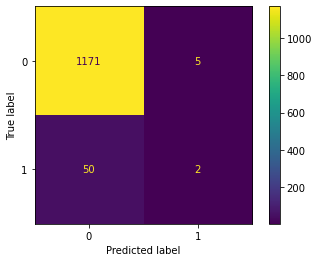

In [109]:
plot_confusion_matrix(grid, X_test, y_test);

In [250]:
X = df.drop(columns = ['stroke', 'id', 0])
y = df.stroke

In [251]:
#np.count_nonzero((predictions == 1) & (y == 1) | (predictions == 0) & (y == 0)) / np.size(y)

In [252]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y)

In [253]:
print(f'Null model accuracy: {round(max(y_test.mean(), 1 - y_test.mean()), 2)}')

Null model accuracy: 0.96


In [254]:
X_train.head(3)

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
608,1,1.277386,1,0,1,2,1,-0.095123,-0.433480,1
341,1,-1.667325,0,0,0,4,0,-0.354214,-1.847000,0
2827,1,1.634320,1,0,0,2,1,-0.040129,-1.005241,0


In [255]:
pipe = make_pipeline(RandomOverSampler(), RandomForestClassifier())

In [256]:
grid = GridSearchCV(estimator = pipe, 
                    param_grid = dict(randomoversampler__sampling_strategy = [0.6, 0.75, 1]))

In [257]:
grid.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('randomoversampler',
                                        RandomOverSampler()),
                                       ('randomforestclassifier',
                                        RandomForestClassifier())]),
             param_grid={'randomoversampler__sampling_strategy': [0.6, 0.75,
                                                                  1]})

In [258]:
y_pred = grid.predict(X_test)

In [259]:
def classification_eval(y_test, y_pred):
    print(f'accuracy  = {np.round(accuracy_score(y_test, y_pred), 3)}')
    print(f'precision = {np.round(precision_score(y_test, y_pred), 3)}')
    print(f'recall    = {np.round(recall_score(y_test, y_pred), 3)}')
    print(f'f1-score  = {np.round(f1_score(y_test, y_pred), 3)}')
    print(f'roc auc   = {np.round(roc_auc_score(y_test, y_pred), 3)}')

classification_eval(y_test, y_pred)

accuracy  = 0.953
precision = 0.091
recall    = 0.023
f1-score  = 0.037
roc auc   = 0.507


In [260]:
grid.best_params_

{'randomoversampler__sampling_strategy': 0.6}

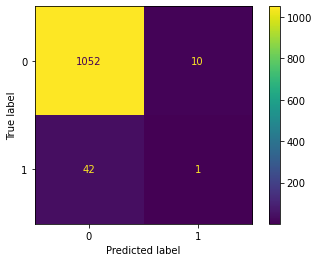

In [261]:
plot_confusion_matrix(grid, X_test, y_test);

In [262]:
from imblearn.over_sampling import SMOTE

sm = SMOTE()
X, y = sm.fit_resample(X, y)

In [263]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y)

In [264]:
rf.fit(X_train, y_train)

RandomForestClassifier()

In [265]:
y_pred = rf.predict(X_test)

In [266]:
def classification_eval(y_test, y_pred):
    print(f'accuracy  = {np.round(accuracy_score(y_test, y_pred), 3)}')
    print(f'precision = {np.round(precision_score(y_test, y_pred), 3)}')
    print(f'recall    = {np.round(recall_score(y_test, y_pred), 3)}')
    print(f'f1-score  = {np.round(f1_score(y_test, y_pred), 3)}')
    print(f'roc auc   = {np.round(roc_auc_score(y_test, y_pred), 3)}')

classification_eval(y_test, y_pred)

accuracy  = 0.95
precision = 0.931
recall    = 0.972
f1-score  = 0.951
roc auc   = 0.95


In [267]:
from imblearn.over_sampling import ADASYN